# Classical full Transductive Conformal Prediction for binary classification


Conformal Prediction is a machine learning framework that allows to quantify prediction uncertainty to produce reliable probabilisic predictions. Conformal Prediction can be used on top of any underlying model and works with any data distribution and any dataset size. 

The goal of this notebook is to help you understand Conformal Prediction for classification problem. We will build a conformal classifier by hand step-by-step explaining the required background on the way.

We will be working with the classical Transductive (Full) Conformal Prediction framework.

In [1]:
#install OpenML
!pip install nonconformist
!pip install openml
!pip install dtype_diet

#install XGBoost
!pip install xgboost
!pip install --upgrade xgboost

#install CatBoost
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.stats import rankdata

import openml

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import label_binarize

import plotly.express as px

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from nonconformist.cp import TcpClassifier
from nonconformist.nc import NcFactory
from nonconformist.nc import InverseProbabilityErrFunc, MarginErrFunc


import warnings
warnings.filterwarnings('ignore')


# Load dataset

In [3]:
# List datasets https://docs.openml.org/Python-API/
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

In [ ]:
datasets_df.head()

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
5,arrhythmia,1,1,active,ARFF,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,206.0,74.0
6,letter,1,1,active,ARFF,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0


In [ ]:
datasets_df.query('NumberOfClasses == 2')

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
13,breast-cancer,1,1,active,ARFF,201.0,11.0,85.0,2.0,10.0,286.0,9.0,9.0,0.0,10.0
15,breast-w,1,1,active,ARFF,458.0,2.0,241.0,2.0,10.0,699.0,16.0,16.0,9.0,1.0
24,mushroom,1,1,active,ARFF,4208.0,12.0,3916.0,2.0,23.0,8124.0,2480.0,2480.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45089,GLI,1,33148,active,arff,59.0,NaN,26.0,2.0,22284.0,85.0,0.0,0.0,22283.0,0.0
45090,Leukemia,2,33148,active,arff,47.0,NaN,25.0,2.0,7130.0,72.0,0.0,0.0,7129.0,0.0
45098,Ovarian,1,33148,active,arff,162.0,NaN,91.0,2.0,15155.0,253.0,0.0,0.0,15154.0,0.0


In [4]:
# output information about selected dataset
datasets_df.loc[31]

name                                  credit-g
version                                      1
uploader                                     1
status                                  active
format                                    ARFF
MajorityClassSize                        700.0
MaxNominalAttDistinctValues               10.0
MinorityClassSize                        300.0
NumberOfClasses                            2.0
NumberOfFeatures                          21.0
NumberOfInstances                       1000.0
NumberOfInstancesWithMissingValues         0.0
NumberOfMissingValues                      0.0
NumberOfNumericFeatures                    7.0
NumberOfSymbolicFeatures                  14.0
Name: 31, dtype: object

In [5]:
# German credit dataset https://www.openml.org/d/31
dataset = openml.datasets.get_dataset(31)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'credit-g', the target feature is 'class'
URL: https://api.openml.org/data/v1/download/31/credit-g.arff
**Author**: Dr. Hans Hofmann  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

**German Credit dataset**  
This dataset classifies people described by a set of attributes as good or bad credit risks.

This dataset comes with a cost matrix: 
``` 
Good  Bad (predicted)  
Good   0    1   (actual)  
Bad    5    0  
```

It is worse to class a customer as good when they are 


In [6]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

In [7]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,0.0,6.0,4.0,3.0,1169.0,4.0,4.0,4.0,2.0,0.0,...,0.0,67.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,0
1,1.0,48.0,2.0,3.0,5951.0,0.0,2.0,2.0,1.0,0.0,...,0.0,22.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,1
2,3.0,12.0,4.0,6.0,2096.0,0.0,3.0,2.0,2.0,0.0,...,0.0,49.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0
3,0.0,42.0,2.0,2.0,7882.0,0.0,3.0,2.0,2.0,2.0,...,1.0,45.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0
4,0.0,24.0,3.0,0.0,4870.0,0.0,2.0,3.0,2.0,0.0,...,3.0,53.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,1


In [8]:
df['class'].value_counts()

0    700
1    300
Name: class, dtype: int64

## Split into training and test set

In [9]:
X = df.drop('class', axis = 1)
y = df['class']

In [10]:
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,0.0,6.0,4.0,3.0,1169.0,4.0,4.0,4.0,2.0,0.0,4.0,0.0,67.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0
1,1.0,48.0,2.0,3.0,5951.0,0.0,2.0,2.0,1.0,0.0,2.0,0.0,22.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0
2,3.0,12.0,4.0,6.0,2096.0,0.0,3.0,2.0,2.0,0.0,3.0,0.0,49.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0
3,0.0,42.0,2.0,2.0,7882.0,0.0,3.0,2.0,2.0,2.0,4.0,1.0,45.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0
4,0.0,24.0,3.0,0.0,4870.0,0.0,2.0,3.0,2.0,0.0,4.0,3.0,53.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0


In [11]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: class, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Train Logistic Regression

In [13]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [14]:
# make point predictions and obtain class scores
y_pred_test = model.predict(X_test)
y_pred_score_test = model.predict_proba(X_test)

In [15]:
print('Classification accuracy: {}'.format(accuracy_score(y_test, y_pred_test)))

Classification accuracy: 0.78


In [16]:
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_pred_score_test[:,1]))) 

ROC AUC: 0.7926190476190477


In [17]:
# predict classification scores on the training set
y_pred_score_train = model.predict_proba(X_train)

In [18]:
y_pred_score_train

array([[0.5570891 , 0.4429109 ],
       [0.82856182, 0.17143818],
       [0.51582293, 0.48417707],
       ...,
       [0.8635868 , 0.1364132 ],
       [0.79077331, 0.20922669],
       [0.87184434, 0.12815566]])

In [19]:
y_train

828    1
997    0
148    0
735    0
130    0
      ..
492    0
545    1
298    0
417    0
749    0
Name: class, Length: 800, dtype: int64

In [20]:
x = X_test.iloc[0]
x

checking_status              1.0
duration                    18.0
credit_history               2.0
purpose                      9.0
credit_amount             1913.0
savings_status               3.0
employment                   1.0
installment_commitment       3.0
personal_status              3.0
other_parties                0.0
residence_since              3.0
property_magnitude           0.0
age                         36.0
other_payment_plans          0.0
housing                      1.0
existing_credits             1.0
job                          2.0
num_dependents               1.0
own_telephone                1.0
foreign_worker               0.0
Name: 30, dtype: float32

In [21]:
y = y_test.iloc[0]
y

0

In [22]:
y_pred_score_test[0]

array([0.79763407, 0.20236593])

# Define non-conformity measure



In [23]:
# We use inverse probability nonconformity measure (also known as hinge loss). The function below calculates the probability of not predicting the correct class by simply looking up
# probability score predicted by the underlying model for the correct class and subtracting it from 1.
# For each correct output in y, inverse probablity nonconformity (hinge loss) score  is defined as math:: 1 - \hat{P}(y_i | x)
# This measure is also known as a hinge loss and is based simply on the probability estimate provided by the underlying point classification model for the correct class label y_i 

def InverseProbabilityNC(predicted_score, y):
  prob = np.zeros(y.size, dtype=np.float32)
  for i, y_ in enumerate(y):
    if y_ >= predicted_score.shape[1]:
      prob[i] = 0
    else:
      prob[i] = predicted_score[i, int(y_)]
  return 1 - prob

In [24]:
X_train

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
828,0.0,36.0,2.0,1.0,8335.0,4.0,4.0,3.0,2.0,0.0,4.0,3.0,47.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0
997,3.0,12.0,2.0,3.0,804.0,0.0,4.0,4.0,2.0,0.0,4.0,2.0,38.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0
148,0.0,36.0,4.0,2.0,5371.0,0.0,2.0,3.0,2.0,2.0,2.0,1.0,28.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0
735,1.0,36.0,1.0,4.0,3990.0,4.0,1.0,3.0,1.0,0.0,2.0,3.0,29.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
130,1.0,48.0,2.0,0.0,8487.0,4.0,3.0,1.0,1.0,0.0,2.0,2.0,24.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,3.0,6.0,4.0,3.0,1237.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,27.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0
545,0.0,24.0,3.0,0.0,1333.0,0.0,0.0,4.0,2.0,0.0,2.0,0.0,43.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
298,3.0,18.0,2.0,2.0,2515.0,0.0,2.0,3.0,2.0,0.0,4.0,0.0,43.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0
417,0.0,18.0,3.0,6.0,8471.0,4.0,2.0,1.0,1.0,0.0,2.0,2.0,23.0,2.0,0.0,2.0,2.0,1.0,1.0,0.0


In [25]:
# Let us see how Transductive Conformal Prediction works using the first point from the test dataset
pd.DataFrame(X_test.iloc[0]).T

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
30,1.0,18.0,2.0,9.0,1913.0,3.0,1.0,3.0,3.0,0.0,3.0,0.0,36.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0


In [26]:
# Here, we concatenate the first point from the test dataset to the training data set 
X_train_plus_test = pd.concat([X_train,pd.DataFrame(X_test.iloc[0]).T])
X_train_plus_test

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
828,0.0,36.0,2.0,1.0,8335.0,4.0,4.0,3.0,2.0,0.0,4.0,3.0,47.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0
997,3.0,12.0,2.0,3.0,804.0,0.0,4.0,4.0,2.0,0.0,4.0,2.0,38.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0
148,0.0,36.0,4.0,2.0,5371.0,0.0,2.0,3.0,2.0,2.0,2.0,1.0,28.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0
735,1.0,36.0,1.0,4.0,3990.0,4.0,1.0,3.0,1.0,0.0,2.0,3.0,29.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
130,1.0,48.0,2.0,0.0,8487.0,4.0,3.0,1.0,1.0,0.0,2.0,2.0,24.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0.0,24.0,3.0,0.0,1333.0,0.0,0.0,4.0,2.0,0.0,2.0,0.0,43.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
298,3.0,18.0,2.0,2.0,2515.0,0.0,2.0,3.0,2.0,0.0,4.0,0.0,43.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0
417,0.0,18.0,3.0,6.0,8471.0,4.0,2.0,1.0,1.0,0.0,2.0,2.0,23.0,2.0,0.0,2.0,2.0,1.0,1.0,0.0
749,3.0,15.0,2.0,1.0,3029.0,0.0,3.0,2.0,2.0,0.0,2.0,2.0,33.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0


In [27]:
y_pred_score_train

array([[0.5570891 , 0.4429109 ],
       [0.82856182, 0.17143818],
       [0.51582293, 0.48417707],
       ...,
       [0.8635868 , 0.1364132 ],
       [0.79077331, 0.20922669],
       [0.87184434, 0.12815566]])

In [28]:
# we create two datasets for potential labels for the first point from the test dataset
y_train_plus_test_0 = np.append(y_train, 0)
y_train_plus_test_1 = np.append(y_train, 1)

In [29]:
# We fit the classifier twice using both potential labels 0 & 1. Here we fit the classifier using the potential label 0 and predict class scores for the new object if it had label 0
model.fit(X_train_plus_test, y_train_plus_test_0)
y_pred_score_train_plus_test_0 = model.predict_proba(X_train_plus_test)

In [30]:
# We fit the classifier twice using both potential labels 0 & 1. Here we fit the classifier using the potential label 1 and predict class scores for the new object if it had label 1
model.fit(X_train_plus_test, y_train_plus_test_1)
y_pred_score_train_plus_test_1 = model.predict_proba(X_train_plus_test)

In [31]:
y_pred_score_train_plus_test_0

array([[0.52229377, 0.47770623],
       [0.85041387, 0.14958613],
       [0.58741138, 0.41258862],
       ...,
       [0.75769659, 0.24230341],
       [0.88672217, 0.11327783],
       [0.79741938, 0.20258062]])

In [32]:
y_pred_score_train_plus_test_1

array([[0.56318073, 0.43681927],
       [0.8350298 , 0.1649702 ],
       [0.52176357, 0.47823643],
       ...,
       [0.78155156, 0.21844844],
       [0.87583293, 0.12416707],
       [0.77329667, 0.22670333]])

In [34]:
y_pred_score_train_plus_test_0[-1,:]

array([0.79741938, 0.20258062])

In [35]:
y_pred_score_train_plus_test_1[-1,:]

array([0.77329667, 0.22670333])

In [36]:
# we calculate nonconformity scores for both situations - potential labels 0 & 1 
non_conformity_scores_train_plus_test_0 = InverseProbabilityNC(y_pred_score_train_plus_test_0, y_train_plus_test_0)
non_conformity_scores_train_plus_test_1 = InverseProbabilityNC(y_pred_score_train_plus_test_1, y_train_plus_test_1)

In [37]:
# extract nonconformity scores for the training set and the new test point
non_conformity_scores_y_train_class_0 = non_conformity_scores_train_plus_test_0[:-1]
non_conformity_scores_y_train_class_1 = non_conformity_scores_train_plus_test_1[:-1]

non_conformity_scores_y_test_class_0 = non_conformity_scores_train_plus_test_0[-1]
non_conformity_scores_y_test_class_1 = non_conformity_scores_train_plus_test_1[-1]

In [38]:
# function computes p-values for the test set using classical definition as per Vovk's book by essentially comparing the nonconformity score of the new test point
# with the nonconformity scores of the points in the training set and computing ratio (with test point added to the same 'bag' as training points) of the # of training points
# that have nonconformity scores greater than equal to that of the new test point
  
def compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
  p_values = []
  if not isinstance(non_conformity_scores_test, list):
    non_conformity_scores_test = [non_conformity_scores_test]

  for i, test_point_conformity_score in enumerate(non_conformity_scores_test):
    p_value = (np.sum(non_conformity_scores_train >= test_point_conformity_score) + 1) / (len(non_conformity_scores_train)+1)
    p_values.append(p_value)  
  return np.array(p_values)

In [39]:
# compute p-value of the test point twice, each time assigning potential label 0 and 1
p_value_class_0 = compute_p_value(non_conformity_scores_y_train_class_0, non_conformity_scores_y_test_class_0)
p_value_class_1 = compute_p_value(non_conformity_scores_y_train_class_1, non_conformity_scores_y_test_class_1)

In [40]:
print('p-value for class 0: {}, p-value for class 1: {}'.format(p_value_class_0,p_value_class_1))

p-value for class 0: [0.57677903], p-value for class 1: [0.06491885]


In [ ]:
# Alternative way to compute p-values using ranks of nonconformity scores

# def compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
#   p_values = []
#   if not isinstance(non_conformity_scores_test, list):
#     non_conformity_scores_test = [non_conformity_scores_test]

#   # Step 1 - sort non_conformity_scores_train in descending order
#   A_sorted = np.sort(non_conformity_scores_train)[::-1]
#   # Step 2 - calculate the rank R of the test instance's nonconformity score, the rank is position in the sorted sequence where nonconformity score alpha for the test object will be inserted
#   for i,_ in enumerate(non_conformity_scores_test):
#     A_sorted_append = np.append(A_sorted, non_conformity_scores_test[i])
#     R = rankdata(A_sorted_append)[-1]
#   # Step 3 - p-value is computed using rank R as: p_value = R / (n+1), where n is the length of the training set
#     p_value = R / (len(non_conformity_scores_train)+1)
#     p_values.append(p_value)  
#   return np.array(p_values)

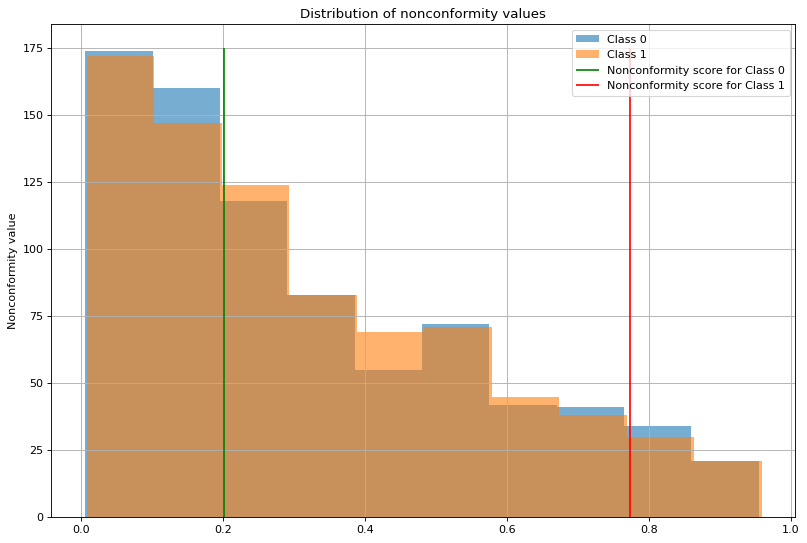

In [41]:
# plot distribution of nonconformity score for both situations

plt.figure(figsize=(12, 8), dpi=80)
plt.hist(np.sort(non_conformity_scores_y_train_class_0), label='Class 0', alpha=0.6)
plt.hist(np.sort(non_conformity_scores_y_train_class_1), label='Class 1', alpha=0.6)
# single line
plt.vlines(x = non_conformity_scores_y_test_class_0, ymin = 0, ymax = 175, colors = 'green',
           label = 'Nonconformity score for Class 0')

plt.vlines(x = non_conformity_scores_y_test_class_1, ymin = 0, ymax = 175, colors = 'red',
           label = 'Nonconformity score for Class 1')

plt.grid(True)
plt.ylabel('Nonconformity value')
plt.title('Distribution of nonconformity values')
 
plt.legend( loc='upper right')
plt.show()

In [43]:
# Function computes prediction sets - here we essentially collect all the steps done above into one function
# Function takes training set, test points, underlying classifier, significance level
# Function returns for each test point, prediction sets and two sets of p-values for each potential label 0 & 1 

def prediction_sets(X_train, y_train, X_test, y_test, model = LogisticRegression(), significance_level = 0.05):

    prediction_sets = []
    p_values_class_0 = []
    p_values_class_1 = []

    for i,y in enumerate(y_test):
      # add test point to the training set 
      X_train_plus_test = pd.concat([X_train,pd.DataFrame(X_test.iloc[i]).T])
      y_train_plus_test_0 = np.append(y_train, 0)
      y_train_plus_test_1 = np.append(y_train, 1)

      # train the underlying classifier twice - two models for each potential value of the lable - 0 and 1
      model.fit(X_train_plus_test, y_train_plus_test_0)
      y_pred_score_train_plus_test_0 = model.predict_proba(X_train_plus_test)
      model.fit(X_train_plus_test, y_train_plus_test_1)
      y_pred_score_train_plus_test_1 = model.predict_proba(X_train_plus_test)

      #compute nonconformity scores
      non_conformity_scores_train_plus_test_0 = InverseProbabilityNC(y_pred_score_train_plus_test_0, y_train_plus_test_0)
      non_conformity_scores_train_plus_test_1 = InverseProbabilityNC(y_pred_score_train_plus_test_1, y_train_plus_test_1)

      non_conformity_scores_y_train_class_0 = non_conformity_scores_train_plus_test_0[:-1]
      non_conformity_scores_y_train_class_1 = non_conformity_scores_train_plus_test_1[:-1]

      non_conformity_scores_y_test_class_0 = non_conformity_scores_train_plus_test_0[-1]
      non_conformity_scores_y_test_class_1 = non_conformity_scores_train_plus_test_1[-1]

      p_value_class_0 = compute_p_value(non_conformity_scores_y_train_class_0, non_conformity_scores_y_test_class_0)
      p_value_class_1 = compute_p_value(non_conformity_scores_y_train_class_1, non_conformity_scores_y_test_class_1)

      p_values_class_0.append( p_value_class_0)
      p_values_class_1.append( p_value_class_1)

      if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
        prediction_sets.append([True,True])
      elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
        prediction_sets.append([True,False])
      elif (p_value_class_0 <= significance_level) and (p_value_class_1 >significance_level):
        prediction_sets.append([False,True])
      else:  
        prediction_sets.append([False,False])

    return prediction_sets, p_values_class_0, p_values_class_1

In [44]:
predictions_test_sets, p_values_test_set_class_0, p_values_test_set_class_1 = prediction_sets(X_train, y_train, X_test, y_test, model = LogisticRegression(), significance_level = 0.05)

In [45]:
predictions_test_sets

[[True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, False],
 [True, False],
 [True, True],
 [True, False],
 [True, True],
 [True, True],
 [True, False],
 [True, True],
 [True, False],
 [True, False],
 [True, False],
 [True, False],
 [True, True],
 [True, False],
 [True, True],
 [True, True],
 [True, True],
 [True, False],
 [True, True],
 [True, False],
 [True, False],
 [True, False],
 [True, True],
 [True, False],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [False, True],
 [True, True],
 [True, True],
 [True, False],
 [True, False],
 [True, False],
 [True, False],
 [True, True],
 [True, True],
 [True, False],
 [True, False],
 [True, False],
 [True, False],
 [True, True],
 [True, True],
 [True, True],
 [True, False],
 [True, False],
 [True, False],
 [True, True],
 [True, True],
 [True, False],
 [True, True],
 [True, True],
 [True, True],
 [True, False

In [46]:
# Let's now take open source library nonconformist https://github.com/donlnz/nonconformist and do the same with just a few lines of code

nc = NcFactory.create_nc(model,err_func=InverseProbabilityErrFunc())	# Create a default nonconformity function, this is the inverse probability (hinge loss) nonconformity measure we used above
tcp = TcpClassifier(nc)			# Create a transductive conformal classifier

In [47]:
# Fit the TCP using the proper training set
tcp.fit(X_train, y_train)

In [48]:
# Produce predictions for the test set, with confidence 95%
prediction = tcp.predict(X_test.values, significance=0.05)

In [49]:
# Here we output prediction sets we constructed manually by writing code from scratch and comparing it with the output from Nonconformist. The results are the same.
for i in range(len(predictions_test_sets)):
  print(predictions_test_sets[i], prediction[i, :])

[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [ True  True]
[True, False] [ True False]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, True] [ True  True]
[True, True] [ True  True]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [ True  True]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [ True  True]
[True, True] [

In [50]:
assert (predictions_test_sets, prediction)